In [79]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 
from dataclasses import dataclass

In [161]:
from tables.index import Index
from pandas.core import series
from re import X
class LogisticRegression:
    def __init__(self, learningRate, maxIteration, epsilon, index =None):
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.epsilon = epsilon
        self.w = None
        self.index = index

    def readData(self):
        train1 = pd.read_excel('/content/Lab3_data.xls',sheet_name ='2004--2005 Data')
        test = pd.read_excel('/content/Lab3_data.xls',sheet_name ='2004--2007 Data')
        return train1, test

    def remove_index(self, df, i):
        df = df.drop(i)
        return df

    def splitData(self): 
        t, test = self.readData()

        if self.index == None:
          train = t
        elif type(self.index) == int:
          train = self.remove_index(t,int(self.index))
        else:
          for i in self.index:
            train = self.remove_index(t,i)
            t = train

        self.y_test = test.iloc[:,0]
        self.X_test = test.iloc[:,1:]
        self.y_train = train.iloc[:,0]
        self.X_train = train.iloc[:,1:]

        return self.X_test, self.X_train, self.y_test, self.y_train
    


    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z)) 
        return sig
    
    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        loss = y * np.log(sig) + (1 - y) * np.log(1 - sig)
        cost = -loss.sum()
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        return (sig - y).dot(X)

    def gradientDescent(self, X, y):
        errors = []
        prev_error = float('inf')

        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_error = self.costFunction(X, y)
            errors.append(current_error)

            if np.abs(prev_error - current_error) < self.epsilon:
                print('The model stopped learning')
                break
                
            prev_error = current_error
            
        self.plot_cost(errors)

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
    
    def evaluate(self, y, y_hat):
        y = y == 1
        y_hat = y_hat == 1

        precision = (y & y_hat).sum() / y_hat.sum()
        recall =  (y & y_hat).sum() / y.sum()
        f_score = 2 * (precision * recall) / (precision + recall)

        return precision, recall, f_score

    def fit(self):
        self.X_test, self.X_train, self.y_test, self.y_train = self.splitData()
        self.w = np.zeros(self.X_train.shape[1], dtype=np.float64)
        self.gradientDescent(self.X_train, self.y_train)

        y_hat_train = self.predict(self.X_train)
        y_hat_test = self.predict(self.X_test)

        precision_train, recall_train, f_score_train = self.evaluate(self.y_train, y_hat_train)
        precision_test, recall_test, f_score_test = self.evaluate(self.y_test, y_hat_test)

        print("Training set evaluation - precision: {}, recall: {}, f-score: {}".format(precision_train, recall_train, f_score_train))
        print("Test set evaluation - precision: {}, recall: {}, f-score: {}".format(precision_test, recall_test, f_score_test))

    
    def plot_cost(self,cost_sequence):
        
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()
        
       
        
    def plot(self):
      fig = plt.figure(figsize=(12,8))
      ax = fig.add_subplot(111, projection='3d')

      # Data for three-dimensional scattered points
      ax.scatter3D(self.X_train.iloc[:, 0], self.X_train.iloc[:, 1], 
                  self.sigmoid(self.X_train.dot(self.w)), 
                  c = self.y_train.iloc[:], cmap='viridis', s=100);

      ax.set_xlim3d(55, 80)
      ax.set_ylim3d(80, 240)
      ax.set_xlabel('$x_1$ feature', fontsize=15)
      ax.set_ylabel('$x_2$ feature', fontsize=15, )
      ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

      plt.show()


    
    
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_train.iloc[:, 0], self.X_train.iloc[:, 1], 
                   c=self.y_train.iloc[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_train.iloc[:, 0], self.X_train.iloc[:, 1], 
                   c=self.y_train.iloc[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

100%|██████████| 100000/100000 [04:25<00:00, 376.58it/s]


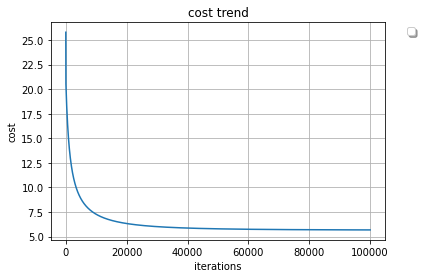

Training set evaluation - precision: 0.9722222222222222, recall: 0.9722222222222222, f-score: 0.9722222222222222
Test set evaluation - precision: 0.9210526315789473, recall: 0.9459459459459459, f-score: 0.9333333333333332


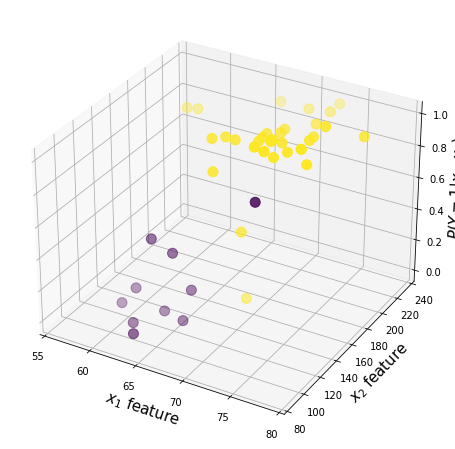

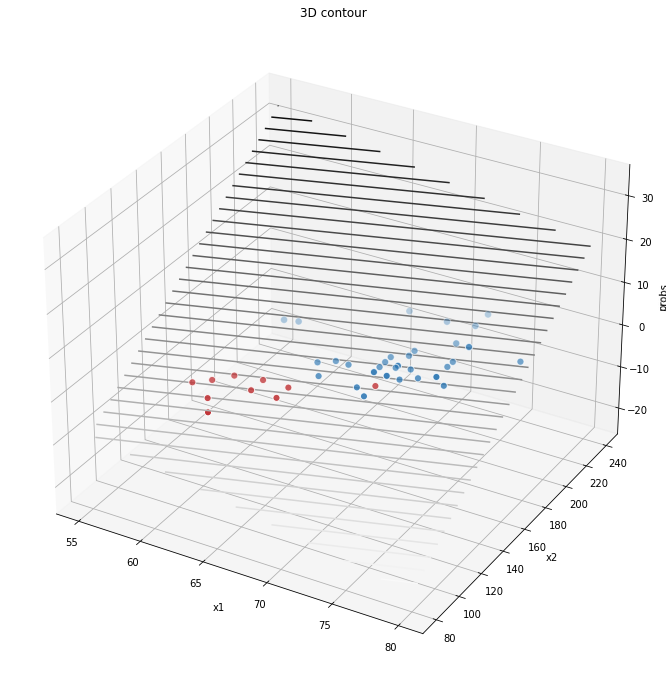

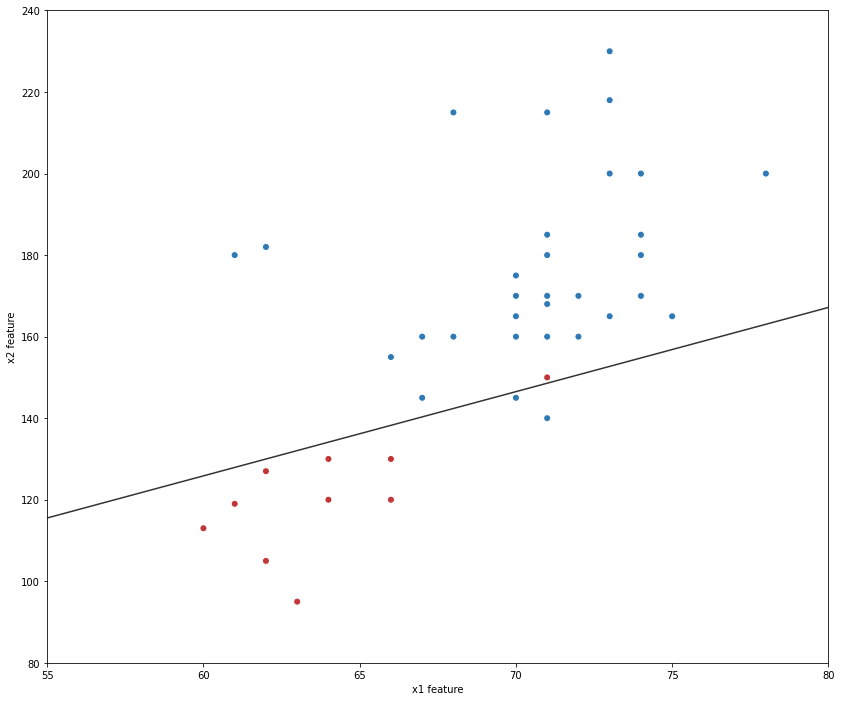

In [167]:
lr = LogisticRegression(epsilon=0.0, learningRate=0.1e-5, maxIteration=100000 )
lr.fit()
lr.plot()
lr.plot3D()
lr.scatterPlt()

100%|██████████| 100000/100000 [04:24<00:00, 378.76it/s]


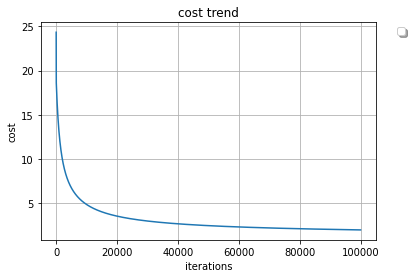

Training set evaluation - precision: 1.0, recall: 0.9714285714285714, f-score: 0.9855072463768115
Test set evaluation - precision: 0.92, recall: 0.9324324324324325, f-score: 0.9261744966442953


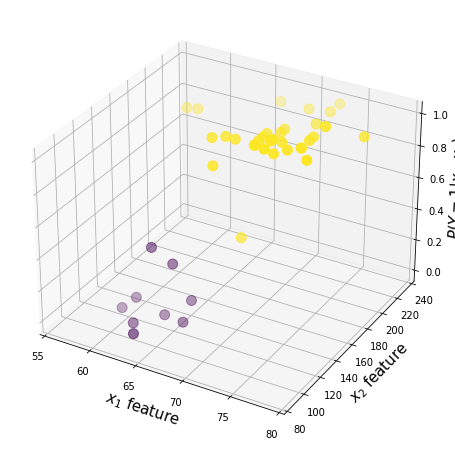

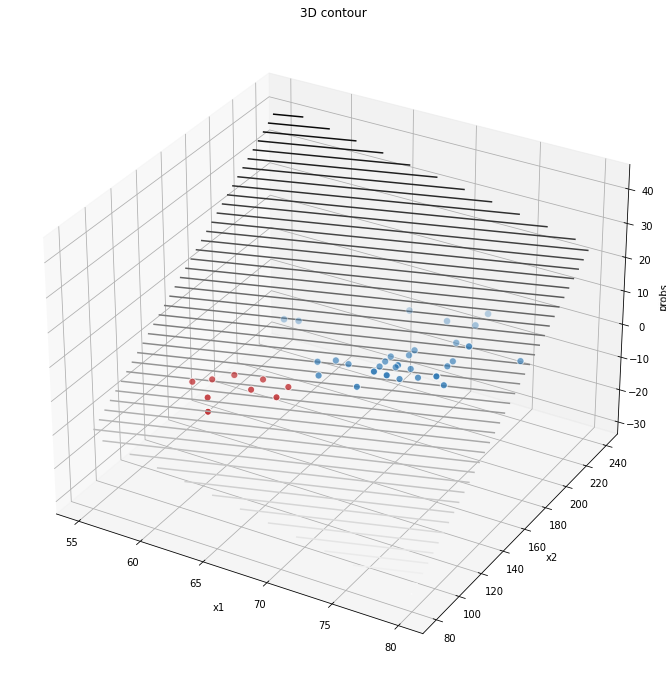

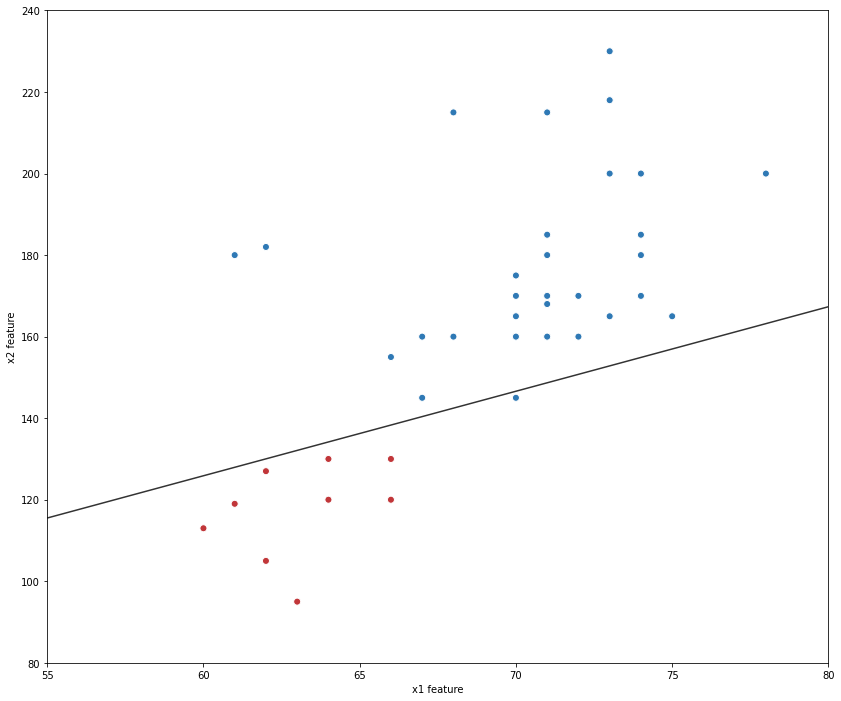

In [166]:
lr = LogisticRegression(epsilon=0.0, learningRate=0.1e-5, maxIteration=100000, index = [0,38] )
lr.fit()
lr.plot()
lr.plot3D()
lr.scatterPlt()

In [172]:
# # for normal data
# Training set evaluation - precision: 0.9722222222222222, recall: 0.9722222222222222, f-score: 0.9722222222222222
# Test set evaluation - precision: 0.9210526315789473, recall: 0.9459459459459459, f-score: 0.9333333333333332

# #for 0,38 data points removed 
# Training set evaluation - precision: 1.0, recall: 0.9714285714285714, f-score: 0.9855072463768115
# Test set evaluation - precision: 0.92, recall: 0.9324324324324325, f-score: 0.9261744966442953

- # we see that index 1 & 39 were missclassified and hence once we removed these points, our prediction recall and f-score metrics have improved. 